# Human proteins Network



In [1]:
import csv
import scipy 
from scipy import sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt

The following lines of code are used to import the adjacency matrix of the human proteins network. 
Then, a scipy sparse matrix is created to store such matrix.

### Import Adjacency matrix

In [2]:
class Network():
    
    def __init__(self,filename):
        self.filename = filename
        self.import_Network()
        
    def import_Network(self):

        list_rows=[]

        with open(self.filename) as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            for row in reader:
                s = row['% asym unweighted'].split()
                list_rows.append(list(map(int, s)) )
    
        vals = np.array(list_rows)

        self.row = vals[:,0]
        self.col = vals[:,1]
        self.data = np.ones(vals.shape[0])
        self.num_vertices = int(np.max(self.col)) + 1
        self.num_edges = int(np.sum(self.data))
        
        
        self.adjacency = scipy.sparse.csr_matrix( (self.data, (self.row,self.col)), 
                                                 shape = (self.num_vertices,self.num_vertices))
        self.set_laplacian_matrix()
        
        
    def set_laplacian_matrix(self):
        out_degree = self.get_outdegree()
        
        self.laplacian = scipy.sparse.lil_matrix((self.num_vertices,self.num_vertices))
        self.laplacian.setdiag(np.array(out_degree).flatten())
        self.laplacian = self.laplacian - scipy.sparse.lil_matrix(self.adjacency)
        self.laplacian = scipy.sparse.csr_matrix(self.laplacian)        
        
        
    def get_indegree(self):
        degs = self.adjacency.sum(axis = 0)
        return degs.flatten()
    
    def get_outdegree(self):
        degs = self.adjacency.sum(axis = 1)
        return degs.flatten()
    

net = Network('out.maayan-figeys')


## NetworkX

We can also define the graph using the NetworkX package.

In [3]:
import networkx as nx

In [4]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

In this notebook, we will explore different network models and compare their properties with our network properties. In particular, we will create *directed* networks according to a model, with the same number of nodes and edges as our network. Then, we will examine the probability distribution of the degree, the average shortest path length and the clustering coefficient of both models.

## 1. Random Network Model

There are two ways of defining this model, either using a fixed number of links, or using a probability of having a link between two nodes. We will explore both.

### Gilbert random graph model

The random network model has two parameters: the number of nodes $N$, and the link probability $p$. The algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.

In this case, the expected number of links, $M$, is:

$$
\mathbb{E}[M] = p \frac{N(N-1)}{2}
$$

where $N$ is the number of nodes. We want to generate a network which is similar to ours. For this reason, we will use the same number of nodes and we will choose $p$ so that the expected number of links is equal to the number of links in our network. This leads to:

$$
p = \frac{2M}{N(N-1)}
$$

where $M$ is the number of links in our network.

Moreover, since our graph is directed we will also generate a directed graph.


In [5]:
N = G.number_of_nodes()
M = G.number_of_edges()
p = M/(N*(N-1))

G_Gil = nx.gnp_random_graph(N, p, directed=True)


Now we try to visualize both networks

**Gilbert Network:**

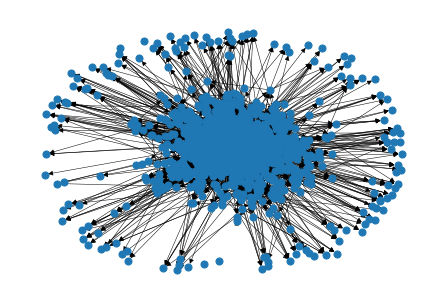

In [130]:
nx.draw(G_Gil, pos=nx.spring_layout(G_Gil), width = 0.5, node_size=50)

**Real Network:**

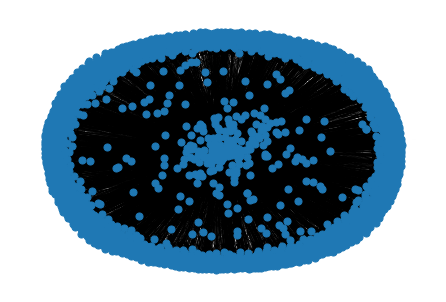

In [131]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

We look at the number of nodes and edges of both networks

In [132]:
print('Real network: number of nodes ', N, ' number of edges ', M)
print('Gilbert network: number of nodes ', G_Gil.number_of_nodes(), ' number of edges ', G_Gil.number_of_edges())

Real network: number of nodes  2240  number of edges  6452
Gilbert network: number of nodes  2240  number of edges  6573


### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges.

In [154]:
G_ER = nx.gnm_random_graph(N,M, directed=True)
print('Real network: number of nodes ', N, ' number of edges ', M)
print('ER network: number of nodes ', G_ER.number_of_nodes(), ' number of edges ', G_ER.number_of_edges())

Real network: number of nodes  2240  number of edges  6452
ER network: number of nodes  2240  number of edges  6452


Despite the small difference regarding the number of edges, both networks are generated randomly, and thus will follow the same properties. Therefore, we will compare only the Gilbert network to the real network.

### Degree distribution

We will now compare the degree distribution of both networks.

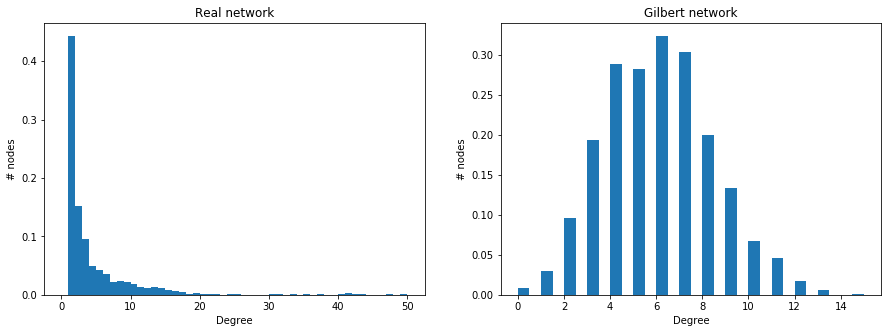

In [133]:
#Real network
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
degrees = dict(G.degree()).values() 
degree_hist = ax1.hist(list(degrees), 50, range=(0,50), density=True)
ax1.set_xlabel('Degree')
ax1.set_ylabel('# nodes')
ax1.set_title('Real network')


#Gilbert network
degrees_Gil = sorted([d for n, d in G_Gil.degree()], reverse=True) 
degree_hist_Gil = ax2.hist(list(degrees_Gil), 30 , density=True)
ax2.set_xlabel('Degree')
ax2.set_ylabel('# nodes')
ax2.set_title('Gilbert network')


plt.show()


We can see that the distributions are very different just by looking at the histogram.

Now we can plot the distributions in a log-log scale to see the decay of the distribution as the degree increases.

Slope of linear fit:  -2.422838637957744


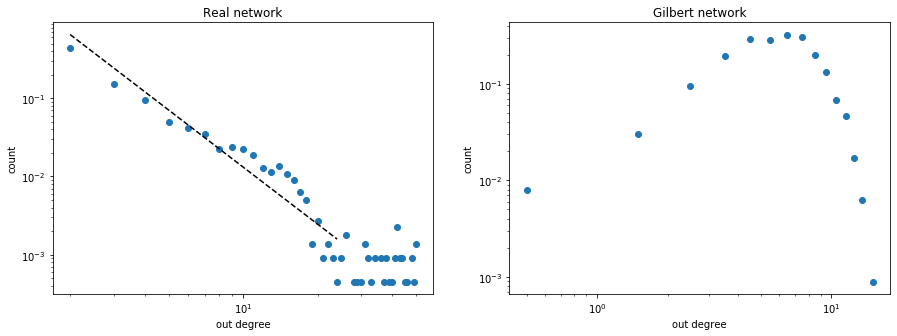

In [139]:
coef = np.polyfit(np.log10(degree_hist[1][2:26]),np.log10(degree_hist[0][1:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(degree_hist[1][2:],degree_hist[0][1:], 'o')
ax1.plot(degree_hist[1][2:25], np.power(10,poly1d_fn(np.log10(degree_hist[1][2:25]))), '--k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Real network")
ax1.set_xlabel('out degree')
ax1.set_ylabel('count')


ax2.plot(degree_hist_Gil[1][1:],degree_hist_Gil[0], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Gilbert network")
ax2.set_xlabel('out degree')
ax2.set_ylabel('count')

plt.show()

The previous plot shows that our network has a distribution degree which follows a power law of parameter approximately of 2.4. On the other hand, the Gilbert network clearly does not follow a power law decrease.
To show that it is in fact an exponential decrease, we will plot the degree distribution using log scale only in the x axis. Then, we will fit a linear model.

Slope of linear fit:  -0.30226481016009366


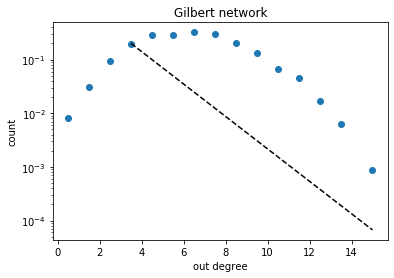

In [142]:
coef = np.polyfit(np.log10(degree_hist_Gil[1][7:]),degree_hist_Gil[0][6:],1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])


plt.plot(degree_hist_Gil[1][1:],degree_hist_Gil[0], 'o')
plt.plot(degree_hist_Gil[1][7:], np.power(10,poly1d_fn(degree_hist_Gil[1][7:])), '--k')
plt.yscale('log')
plt.title("Gilbert network")
plt.xlabel('out degree')
plt.ylabel('count')

plt.show()

In the previous plot we can see that the degree distribution in the Gilbert network has an exponential decay of scale approximately -0.30. Therefore, the degree distribution has a different behaviour than the one from the real network.

### Average length

We will compute the average shortest path lenght of the two models. In order to calculate it, we need to stick to a weakely connected component. We will choose the largest weakely connected component for both graphs.

In [143]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)

largest_cc_Gil = max(nx.weakly_connected_components(G_Gil), key=len)
G_con_Gil = G_Gil.subgraph(largest_cc_Gil)

print('Real network: Average shortest path length: ', nx.average_shortest_path_length(G_con))
print('Gilbert network: Average shortest path length: ', nx.average_shortest_path_length(G_con_Gil))

Real network: Average shortest path lenght:  0.018096339574896314
Gilbert network: Average shortest path lenght:  6.203172379415212


We observe that the average shortest path length of the Gilbert networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of both networks.

In [145]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Gilbert network: Average clustering coefficient:', nx.average_clustering(G_Gil))

Real network: Average clustering coefficient: 0.022991199720053465
Gilbert network: Average clustering coefficient: 0.0011687560125060114


Notice that the average clustering coefficient is much higher for the real network than for the gilbert network. We expected this fact since the clustering property is not a random property, but a social property, and thus it is not present in a random network. 

Real network: Slope of linear fit:  -1.4185448157733733
Gilbert network: Slope of linear fit:  -2.2030513060341796


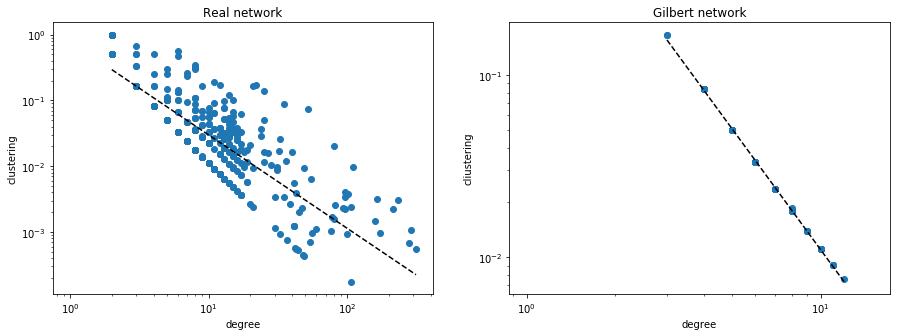

In [153]:
#Real network
clus = nx.clustering(G)
deg = dict(G.degree())

idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Real network: Slope of linear fit: ', coef[0])

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(deg_vals, clus_vals, 'o')
ax1.plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Real network")
ax1.set_xlabel('degree')
ax1.set_ylabel('clustering')


#Gilbert network
clus = nx.clustering(G_Gil)
deg = dict(G_Gil.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Gilbert network: Slope of linear fit: ', coef[0])

ax2.plot(deg_vals, clus_vals, 'o')
ax2.plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax2.set_title("Gilbert network")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('degree')
ax2.set_ylabel('cliustering')
plt.show()

Finally, we plotted the clustering coefficient as a function of the degree of the nodes. We see that both networks present a power law behaviour (which is much clear in the random network). However, the scale of the power law is not the same.

## 2. Small-World Model

Let us now introduce another way of constructing random networks, which is the so called *small-world model*. It can be considered a crossover from regular lattices to random graphs. Its main objective is to provide the randomly generated network with two properties that are very common on real graphs: low average length and high clustering coefficient.

The algorithm for generating a small-world network is as follows:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We will now construct small-world graphs with the same number of nodes and edges as our graph. Notice that the number of edges of such graphs will be $\frac{k}{2}N$. Therefore, if our graph has $M$ edges, then $k$ should be the integer part of $\frac{2M}{N}$. Therefore, it is highly probable that the randomly generated has a little less number of edges.

We are going to create 3 different networks, each one with different values of $p$: 0.2, 0.5 and 0.8. Observe that, as we increase the value of $p$, we are increasing its randomness.

In [11]:
N = G.number_of_nodes()
M = G.number_of_edges()
k = int(2*M/N)

G_SmWd_1 = nx.watts_strogatz_graph(n=N, k=k, p=0.2)
G_SmWd_2 = nx.watts_strogatz_graph(n=N, k=k, p=0.5)
G_SmWd_3 = nx.watts_strogatz_graph(n=N, k=k, p=0.8)

Let us now visualize the networks

**Real Network:**

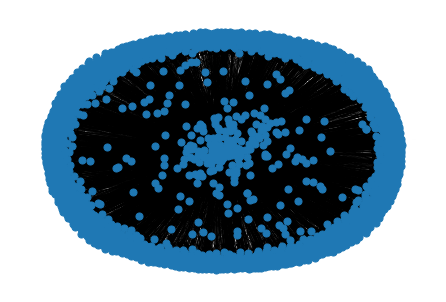

In [131]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

**Small-world Network with p=0.2:**

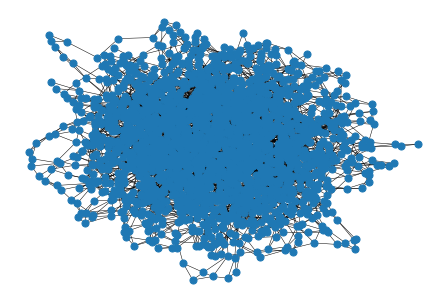

In [12]:
nx.draw(G_SmWd_1, pos=nx.spring_layout(G_SmWd_1), width = 0.5, node_size=50)

**Small-world Network with p=0.5:**

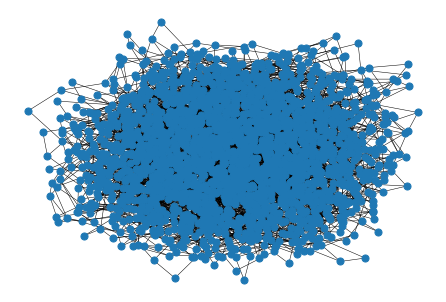

In [13]:
nx.draw(G_SmWd_2, pos=nx.spring_layout(G_SmWd_2), width = 0.5, node_size=50)

**Small-world Network with p=0.8:**

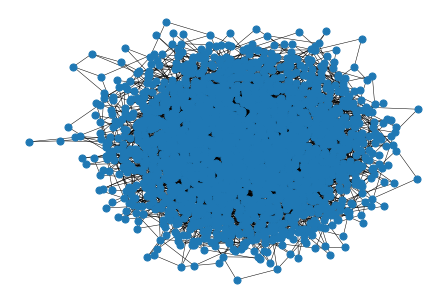

In [14]:
nx.draw(G_SmWd_3, pos=nx.spring_layout(G_SmWd_3), width = 0.5, node_size=50)

We look at the number of nodes and edges of these networks.

In [15]:
print('Real network: number of nodes ', N, ' number of edges ', M)
print('Small-world networks: number of nodes ', G_SmWd_1.number_of_nodes(), ' number of edges ', G_SmWd_1.number_of_edges())

Real network: number of nodes  2240  number of edges  6452
Small-world networks: number of nodes  2240  number of edges  4480


As already mentioned, the number of edges are not the same.

### Degree distribution

We will now compare the degree distribution of these networks. Recall that, in the previous case, we saw that our network followed a power-law distribution.

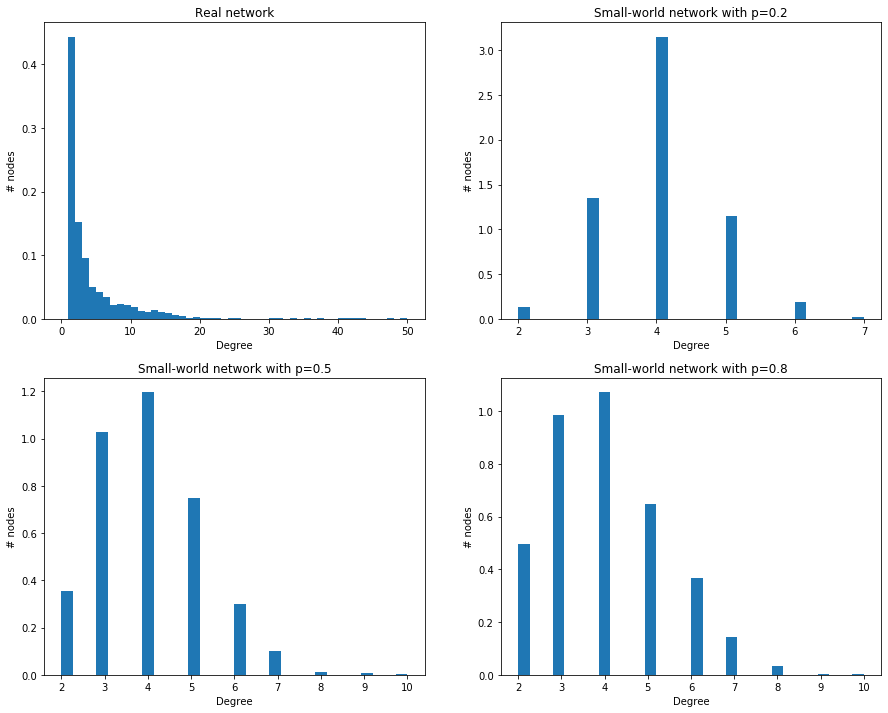

In [29]:
#Real network
f, (ax1, ax2) = plt.subplots(2, 2,figsize=(15,12))
degrees = dict(G.degree()).values() 
degree_hist = ax1[0].hist(list(degrees), 50, range=(0,50), density=True)
ax1[0].set_xlabel('Degree')
ax1[0].set_ylabel('# nodes')
ax1[0].set_title('Real network')


#Small-world networks
degrees_SmWd_1 = sorted([d for n, d in G_SmWd_1.degree()], reverse=True) 
degree_hist_SmWd_1 = ax1[1].hist(list(degrees_SmWd_1), 30 , density=True)
ax1[1].set_xlabel('Degree')
ax1[1].set_ylabel('# nodes')
ax1[1].set_title('Small-world network with p=0.2')

degrees_SmWd_2 = sorted([d for n, d in G_SmWd_2.degree()], reverse=True) 
degree_hist_SmWd_2 = ax2[0].hist(list(degrees_SmWd_2), 30 , density=True)
ax2[0].set_xlabel('Degree')
ax2[0].set_ylabel('# nodes')
ax2[0].set_title('Small-world network with p=0.5')

degrees_SmWd_3 = sorted([d for n, d in G_SmWd_3.degree()], reverse=True) 
degree_hist_SmWd_3 = ax2[1].hist(list(degrees_SmWd_3), 30 , density=True)
ax2[1].set_xlabel('Degree')
ax2[1].set_ylabel('# nodes')
ax2[1].set_title('Small-world network with p=0.8')


plt.show()


By looking at the histograms, we can see that the degree distribution of the small-world networks is not a power-law. This fact was already expected, since the power-low degree distribution is a feature of real graphs but not random graphs.

### Average length

We will compute the average shortest path lenght of the models. As we already did in the previous case, we will stick to the largest connected component for each graph.

In [32]:
#our network
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)

#Small-world networks
largest_cc_SmWd_1 = max(nx.connected_components(G_SmWd_1), key=len)
G_con_SmWd_1 = G_SmWd_1.subgraph(largest_cc_SmWd_1)

largest_cc_SmWd_2 = max(nx.connected_components(G_SmWd_2), key=len)
G_con_SmWd_2 = G_SmWd_2.subgraph(largest_cc_SmWd_2)

largest_cc_SmWd_3 = max(nx.connected_components(G_SmWd_3), key=len)
G_con_SmWd_3 = G_SmWd_3.subgraph(largest_cc_SmWd_3)

print('Real network: Average shortest path lenght: ', nx.average_shortest_path_length(G_con))
print('Small-world network with p=0.2: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_1))
print('Small-world network with p=0.5: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_2))
print('Small-world network with p=0.8: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_3))

Real network: Average shortest path lenght:  0.018096339574896314
Small-world network with p=0.2: Average shortest path lenght:  7.993658680533401
Small-world network with p=0.5: Average shortest path lenght:  6.300217731129969
Small-world network with p=0.8: Average shortest path lenght:  6.016836278951063


We observe that the average shortest path length of the small-world networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of both networks.

In [33]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Small-world network with p=0.2: Average clustering coefficient:', nx.average_clustering(G_SmWd_1))
print('Small-world network with p=0.5: Average clustering coefficient:', nx.average_clustering(G_SmWd_2))
print('Small-world network with p=0.8: Average clustering coefficient:', nx.average_clustering(G_SmWd_3))

Real network: Average clustering coefficient: 0.022991199720053465
Small-world network with p=0.2: Average clustering coefficient: 0.27495535714285807
Small-world network with p=0.5: Average clustering coefficient: 0.0682344812925168
Small-world network with p=0.8: Average clustering coefficient: 0.004745252267573694


Notice that, in the small-world networks, the clustering coefficient is higher as long as $p$ is low. Keep in mind that, as $p$ increases, so does the randomness. And, the clustering is not a random property.

Real network: Slope of linear fit:  -1.4185448157733733
Small-world network with p=0.2: Slope of linear fit:  -1.7466807134971616
Small-world network with p=0.5: Slope of linear fit:  -2.2084476561967405
Small-world network with p=0.8: Slope of linear fit:  -2.3277645366211153


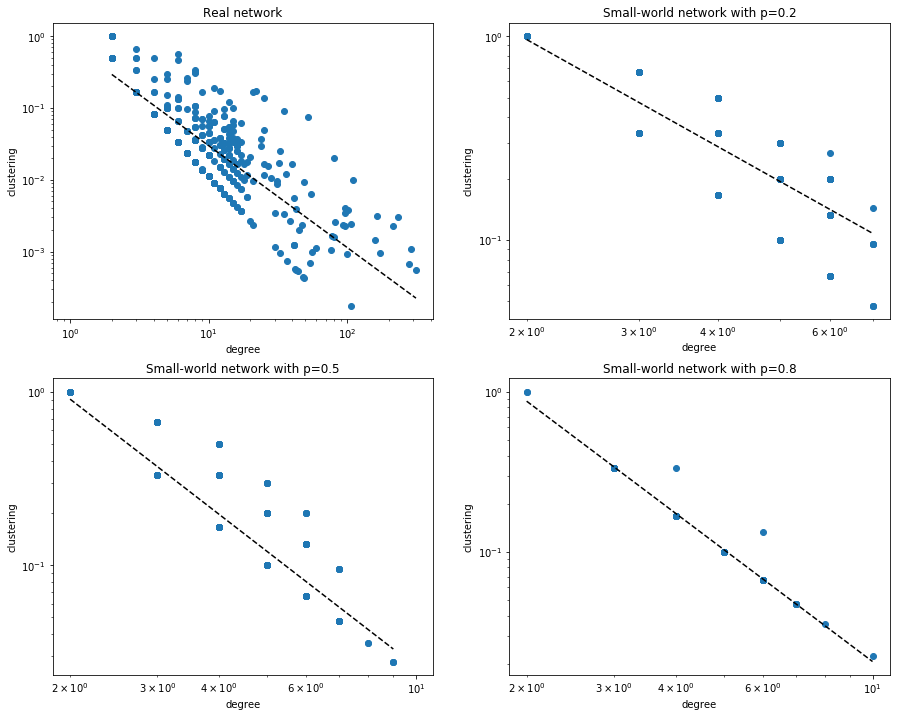

In [41]:
#Real network
clus = nx.clustering(G)
deg = dict(G.degree())

idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Real network: Slope of linear fit: ', coef[0])

f, (ax1, ax2) = plt.subplots(2, 2,figsize=(15,12))
ax1[0].plot(deg_vals, clus_vals, 'o')
ax1[0].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_title("Real network")
ax1[0].set_xlabel('degree')
ax1[0].set_ylabel('clustering')


#Small-world network p=0.2
clus = nx.clustering(G_SmWd_1)
deg = dict(G_SmWd_1.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Small-world network with p=0.2: Slope of linear fit: ', coef[0])

ax1[1].plot(deg_vals, clus_vals, 'o')
ax1[1].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax1[1].set_title("Small-world network with p=0.2")
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('degree')
ax1[1].set_ylabel('clustering')


#Small-world network p=0.5
clus = nx.clustering(G_SmWd_2)
deg = dict(G_SmWd_2.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Small-world network with p=0.5: Slope of linear fit: ', coef[0])

ax2[0].plot(deg_vals, clus_vals, 'o')
ax2[0].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax2[0].set_title("Small-world network with p=0.5")
ax2[0].set_xscale('log')
ax2[0].set_yscale('log')
ax2[0].set_xlabel('degree')
ax2[0].set_ylabel('clustering')


#Small-world network p=0.8
clus = nx.clustering(G_SmWd_3)
deg = dict(G_SmWd_3.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Small-world network with p=0.8: Slope of linear fit: ', coef[0])

ax2[1].plot(deg_vals, clus_vals, 'o')
ax2[1].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax2[1].set_title("Small-world network with p=0.8")
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].set_xlabel('degree')
ax2[1].set_ylabel('clustering')

plt.show()

Finally, we plotted the clustering coefficient as a function of the degree of the nodes. We see that both networks present a power law behaviour. However, this tendency is much clear as the randomness of the graph increases. Notice that the scale of the power law is not the same.

## 3. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$ and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The main point of such construction is to obtain a random graph whose degree distribution follows a power-law.

We are going to construct a Barabási-Albert network with the same number of nodes and edges that our network. Following the notation we used so far, $N$ and $M$ are, respectively, the number of nodes and edges of our network. Notice that, in the Barabási-Albert algorithm, there are $N-m-1$ steps and, in each of them, one node is added. Therefore, the final graph has $(N-m-1)m$ edges. By imposing a total of $M$ edges, we get

$$
M = (N-m-1)m \Leftrightarrow m^2-(N-1)m+M=0 \Leftrightarrow m=\frac{N-1 \pm \sqrt{(N-1)^2-4M}}{2}
$$

Since, we have two possible values of $m$, we will construct two Barabási-Albert networks. Notice that its highly probable that the number of edges of these networks does not coincide with the real one. However, it has the maximum number of edges without exceeding $M$. 

In [83]:
N = G.number_of_nodes()
M = G.number_of_edges()

m_subs = int((N-1-np.sqrt((N-1)**2-4*M))/2)

G_BarAl_1 = nx.barabasi_albert_graph(N, m_subs)
G_BarAl_2 = nx.barabasi_albert_graph(N, N-m_subs)

In [84]:
print("The two values of m we are considering are {} and {}".format(m_subs, N-m_subs))

The two values of m we are considering are 2 and 2238


Let us now visualize the networks

**Real Network:**

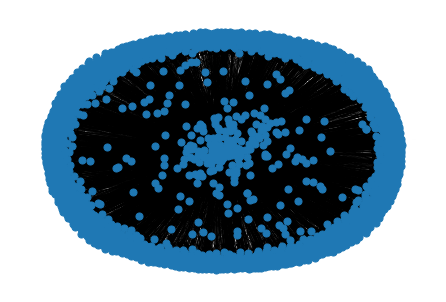

In [131]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

**Barabási-Albert with m=2:**

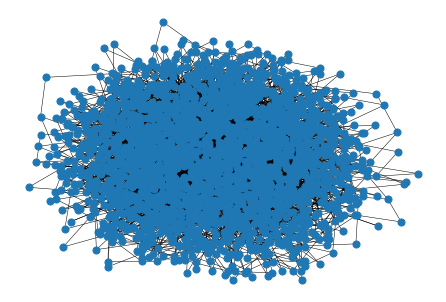

In [52]:
nx.draw(G_BarAl_1, pos=nx.spring_layout(G_BarAl_1), width = 0.5, node_size=50)

**Barabási-Albert with m=2238:**

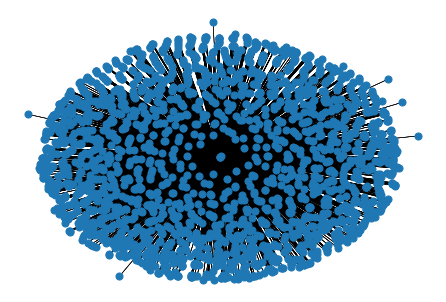

In [53]:
nx.draw(G_BarAl_2, pos=nx.spring_layout(G_BarAl_2), width = 0.5, node_size=50)

We look at the number of nodes and edges of these networks.

In [86]:
print('Real network: number of nodes ', N, ' number of edges ', M)
print('Barabási-Albert network with m=2: number of nodes ', G_BarAl_1.number_of_nodes(), ' number of edges ', G_BarAl_1.number_of_edges())
print('Barabási-Albert network with m=2238: number of nodes ', G_BarAl_2.number_of_nodes(), ' number of edges ', G_BarAl_2.number_of_edges())

Real network: number of nodes  2240  number of edges  6452
Barabási-Albert network with m=2: number of nodes  2240  number of edges  4476
Barabási-Albert network with m=2238: number of nodes  2240  number of edges  4476


### Degree distribution

We will now compare the degree distribution of these networks. We already know that our network follows a power-law distribution.

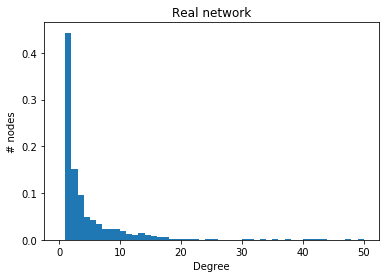

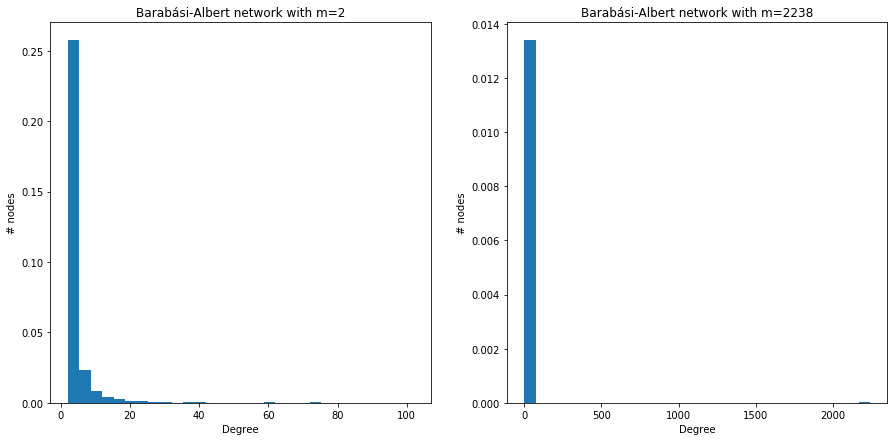

In [99]:
#Real network

f, ax = plt.subplots(1, 1)
degrees = dict(G.degree()).values() 
degree_hist = ax.hist(list(degrees), 50, range=(0,50), density=True)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Real network')
plt.show


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
#Barabási-Albert network with m=2
degrees_BarAl_1 = sorted([d for n, d in G_BarAl_1.degree()], reverse=True) 
degree_hist_BarAl_1 = ax1.hist(list(degrees_BarAl_1), 30 , density=True)
ax1.set_xlabel('Degree')
ax1.set_ylabel('# nodes')
ax1.set_title('Barabási-Albert network with m=2')

#Barabási-Albert network with m=2238
degrees_BarAl_2 = sorted([d for n, d in G_BarAl_2.degree()], reverse=True) 
degree_hist_BarAl_2 = ax2.hist(list(degrees_BarAl_2), 30 , density=True)
ax2.set_xlabel('Degree')
ax2.set_ylabel('# nodes')
ax2.set_title('Barabási-Albert network with m=2238')

plt.show()


By looking at the histograms, we can see that their degree distributions are actually power-laws. Let us now plot the distributions in a log-log scale to see the decay of the distribution as the degree increases.

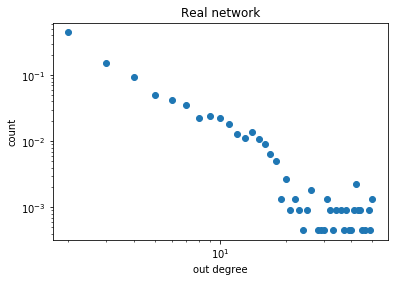

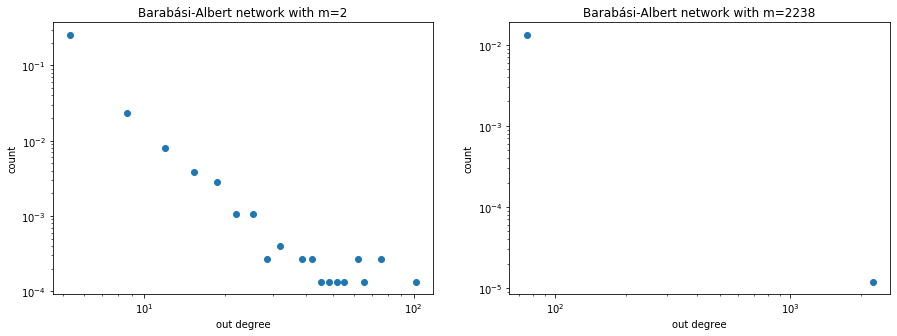

In [111]:
#Real network
f, ax = plt.subplots(1, 1)
plt.plot(degree_hist[1][2:],degree_hist[0][1:], 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Real network")
plt.xlabel('out degree')
plt.ylabel('count')


#Barabási-Albert networks
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(degree_hist_BarAl_1[1][1:],degree_hist_BarAl_1[0], 'o')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Barabási-Albert network with m=2")
ax1.set_xlabel('out degree')
ax1.set_ylabel('count')

ax2.plot(degree_hist_BarAl_2[1][1:],degree_hist_BarAl_2[0], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Barabási-Albert network with m=2238")
ax2.set_xlabel('out degree')
ax2.set_ylabel('count')

plt.show()

Notice that the last histogram only has two points. This is due to the fact that the Barabási-Albert algorithm begins with 2238 nodes. Then, it adds one node and 2237 edges. This step is performed one more time. Therefore, the nodes can have 0, 1 or 2 edges. 

### Average length

We will compute the average shortest path lenght of the models. As we already did in the previous case, we will stick to the largest connected component for each graph.

In [112]:
#our network
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)

#Small-world networks
largest_cc_BarAl_1 = max(nx.connected_components(G_BarAl_1), key=len)
G_con_BarAl_1 = G_BarAl_1.subgraph(largest_cc_BarAl_1)

largest_cc_BarAl_2 = max(nx.connected_components(G_BarAl_2), key=len)
G_con_BarAl_2 = G_BarAl_2.subgraph(largest_cc_BarAl_2)

print('Real network: Average shortest path lenght: ', nx.average_shortest_path_length(G_con))
print('Barabási-Albert network with m=2: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_BarAl_1))
print('Barabási-Albert network with m=2238: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_BarAl_2))


Real network: Average shortest path lenght:  0.018096339574896314
Barabási-Albert network with m=2: Average shortest path lenght:  4.460333854399285
Barabási-Albert network with m=2238: Average shortest path lenght:  1.9982150832642123


We observe that the average shortest path length of the Barabási-Albert networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of the networks.

In [113]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Barabási-Albert network with m=2: Average clustering coefficient:', nx.average_clustering(G_BarAl_1))
print('Barabási-Albert network with m=2238: Average clustering coefficient:', nx.average_clustering(G_BarAl_2))

Real network: Average clustering coefficient: 0.022991199720053465
Barabási-Albert network with m=2: Average clustering coefficient: 0.01655327794020716
Barabási-Albert network with m=2238: Average clustering coefficient: 0.9986615118356409


In the random networks, the clustering coefficient is quite high. Notice the fact that such coefficient is almost 1 when m=2238. This makes sense since, in such case, the Barabási-Albert algorithm only performs two steps.

Real network: Slope of linear fit:  -1.4185448157733733
Barabási-Albert network with m=2: Slope of linear fit:  -1.7920221352580752
Barabási-Albert network with m=2238: Slope of linear fit:  -1.0000318315706873


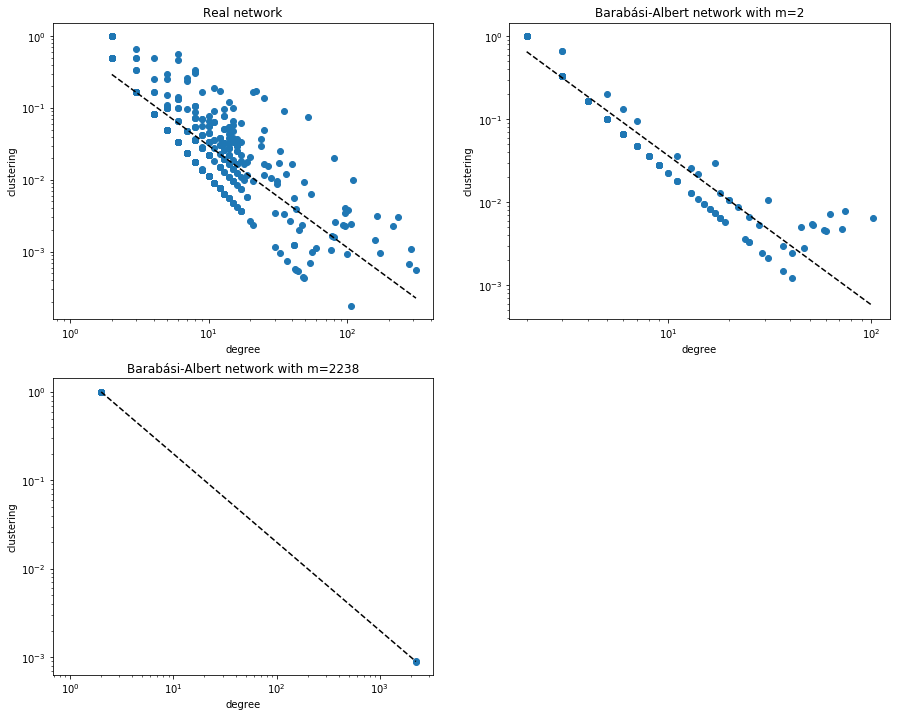

In [120]:
#Real network
clus = nx.clustering(G)
deg = dict(G.degree())

idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Real network: Slope of linear fit: ', coef[0])

f, ax = plt.subplots(2, 2,figsize=(15,12))
ax[0,0].plot(deg_vals, clus_vals, 'o')
ax[0,0].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_title("Real network")
ax[0,0].set_xlabel('degree')
ax[0,0].set_ylabel('clustering')


#Barabási-Albert with m=2
clus = nx.clustering(G_BarAl_1)
deg = dict(G_BarAl_1.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Barabási-Albert network with m=2: Slope of linear fit: ', coef[0])

ax[0,1].plot(deg_vals, clus_vals, 'o')
ax[0,1].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax[0,1].set_title("Barabási-Albert network with m=2")
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('degree')
ax[0,1].set_ylabel('clustering')


#Barabási-Albert with m=2238
clus = nx.clustering(G_BarAl_2)
deg = dict(G_BarAl_2.degree())
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Barabási-Albert network with m=2238: Slope of linear fit: ', coef[0])

ax[1,0].plot(deg_vals, clus_vals, 'o')
ax[1,0].plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax[1,0].set_title("Barabási-Albert network with m=2238")
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('degree')
ax[1,0].set_ylabel('clustering')

f.delaxes(ax[1,1])
plt.show()

Finally, we plotted the clustering coefficient as a function of the degree of the nodes. We see that all of them present a power law behaviour. Notice that the scale of the power law is not the same, although quite similar.